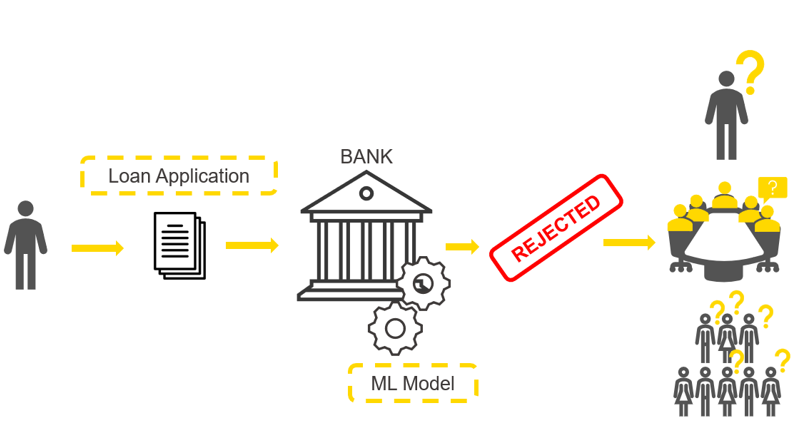

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Lets Load the data</span>
</div>

In [1]:
# Importing the .py file for below actions.
from XAI_Prototype_Final import *

#Loading the data
df = pd.read_csv('RAIdata.csv')
df.head()

Unnamed: 0   Age  AppliedAmount  DebtToIncome  ExpectedLoss  \
0           0  54.0         8505.0           0.0      0.118622   
1           1  52.0         2230.0           0.0      0.059200   
2           2  28.0          530.0           0.0      0.048764   
3           3  40.0         1380.0           0.0      0.071894   
4           4  31.0          530.0           0.0      0.043700   

   LiabilitiesTotal  FreeCash  IncomeFromChildSupport  \
0             87.82       0.0                     0.0   
1            309.23       0.0                     0.0   
2            143.58       0.0                     0.0   
3             70.65       0.0                     0.0   
4            719.42       0.0                     0.0   

   IncomeFromFamilyAllowance  IncomeFromLeavePay  ...  VerificationType_2.0  \
0                        0.0                 0.0  ...                     0   
1                        0.0                 0.0  ...                     0   
2                        0.0                 0.0  ...                     0   
3                        0.0                 0.0  ...                     0   
4                        0.0                 0.0  ...                     0   

   VerificationType_3.0  VerificationType_4.0  WorkExperience_10To15Years  \
0                     0                     0                           0   
1                     0                     0                           0   
2                     0                     0                           0   
3                     0                     0                           0   
4                     0                     1                           0   

   WorkExperience_15To25Years  WorkExperience_2To5Years  \
0                           0                         0   
1                           0                         1   
2                           0                         1   
3                           0                         0   
4                           0                         0   

   WorkExperience_5To10Years  WorkExperience_LessThan2Years  \
0                          1                              0   
1                          0                              0   
2                          0                              0   
3                          1                              0   
4                          0                              1   

   WorkExperience_MoreThan25Years  Young  
0                               0      0  
1                               0      0  
2                               0      1  
3                               0      0  
4                               0      1  

[5 rows x 206 columns]

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Now lets Explore the data</span>
</div>

In [2]:
#Dropping non-defined column and Duplicates from the data. 
df.drop_duplicates(subset=None,keep='first',inplace=True)
df.drop(columns="Unnamed: 0", inplace=True)

In [3]:
# check for null values
df.isnull().sum()

Age                                  0
AppliedAmount                        0
DebtToIncome                        45
ExpectedLoss                      2630
LiabilitiesTotal                     0
                                  ... 
WorkExperience_2To5Years             0
WorkExperience_5To10Years            0
WorkExperience_LessThan2Years        0
WorkExperience_MoreThan25Years       0
Young                                0
Length: 205, dtype: int64

In [4]:
# Imputing the Null values
for col in df.columns:
    if df.isnull().sum()[col]!=0:
        df[col].fillna((df[col].mean()), inplace=True)

# check for null values again
df.isnull().sum().sum()

0

### Function Call IV and PDP Plots

In [5]:
#Calling the defined functions
target_variable = "Default"
independent_features = ['Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal']

data_new=df[['Default','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal']]
full_model = IV_PDP(data_new,independent_features,target_variable)
full_model.fit()
full_model_predictions = full_model.predict()

### Functions Call for Split and Compare Quantiles

In [6]:
def ret_tag(val):
        for i in range(10):
            if val in categories[i]:
                return tags[i]
        
def zero_list_maker(n):
        list_of_zeros = [0] * n
        return list_of_zeros

In [7]:
def bar_width_per_quantile2(SCQ_view, label_filter):
    view_filtered = SCQ_view[SCQ_view['Default'] == label_filter]      
    view_filtered['Tag'] = view_filtered['Score2'].map(lambda x: ret_tag(x))
    len_view_filtered = len(view_filtered)
    view_filtered['ID']=view_filtered.index
    count_pertag_filtered = view_filtered[['ID', 'Tag']].groupby(['Tag']).count().rename(columns={'ID': 'Count'})
    count_pertag_filtered['Perc'] = count_pertag_filtered['Count'] / len(SCQ_view) * 100

    Amt = view_filtered[['ID', 'Tag', 'Amount']].groupby(['Tag'])['Amount'].sum()
    Amt = (Amt/1000).to_list()
    sc = count_pertag_filtered['Perc'].tolist()
    sc = zero_list_maker(10 - len(sc)) + sc 
    return sc, Amt  

In [8]:
#Calling the above defined functions
#1 For Class SCQ
target_variable = "Default"
independent_features = ['Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal']
data_new=df[['Default','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal']]
SCQ = SCQ(data_new,independent_features,target_variable)
SCQ.fit()
SCQ_predictions = SCQ.predict()
SCQ_view = SCQ.create_view("AppliedAmount",'Score',['Default','Score','Amount'])

#2 For ret_tags, zero_lists and Categories
i=5
cuts_by_quantile = pd.qcut(SCQ_view['Score2'], 11, duplicates='drop') 
categories = cuts_by_quantile.value_counts().index.categories
left_bounds = categories.left
right_bounds = categories.right
tags = range(1, 11)

#3 For class bar_width_per_quantile2
sc1, amt1 = bar_width_per_quantile2(SCQ_view, 1)
sc0, amt0 = bar_width_per_quantile2(SCQ_view, 0)

#Defining dataframes for plotting
name = [str(left_bounds[i])+'-'+str(right_bounds[i]) for i in range(10)]

data_p = [(name[i], sc1[i], sc0[i]) for i in range(10)]
data_amt = [(name[i], amt1[i], amt0[i]) for i in range(10)]

df1 = pd.DataFrame(columns=["Range","Label 1", "Label 0"],data=data_p)
df2 = pd.DataFrame(columns=["Range", 'Amount:1', "Amount:0"],data=data_amt)

### Functions Call for GAM

In [9]:
target_variable = "Default"
independent_features = ['Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal']

data_new=df[['Default','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal']]
GAM = GAM(data_new,independent_features,target_variable)
GAM.fit()
GAM_train_acc, GAM_test_acc, GAM_summary  = GAM.predict()

print(f"Train Accuracy: {GAM_train_acc}\n")
print(f"Test Accuracy: {GAM_test_acc}\n")
# print('')
# GAM_summary()

Train Accuracy: 0.7686521526418787

Test Accuracy: 0.7704035874439462



### Functions Defined for CounterFactuals

In [10]:
target_variable = "Default"
independent_features = ['Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal']

data_new=df[['Default','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal']]
CF = CF(data_new,independent_features,target_variable)
CF.fit()
CF.dice_ml()

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">---------------------------------------------XAI Plots--------------------------------------------</span>
</div>

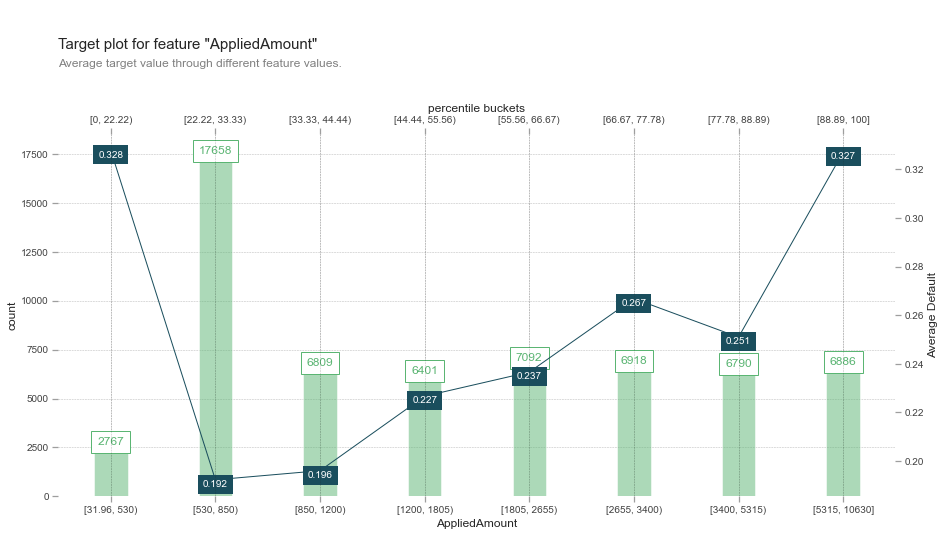

In [11]:
full_model.EDA_PLOT()

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Information Value Plots</span>
</div>

Information value is one of the most useful techniques to select important variables in a model. It helps to rank variables based on their importance and helps to determine the predictive power of the variable.

The underlying concepts of the IV Plots are weight of evidence (WoE) and the information value (IV). WoE helps us quantify the predictive power of a feature on the output, and the IV uses WoE to assign a score (IV) that can be used to compare and 
prioritize the features.This simple technique can help us compare the different features in a single scale and prioritize them based on their influence on the output. 

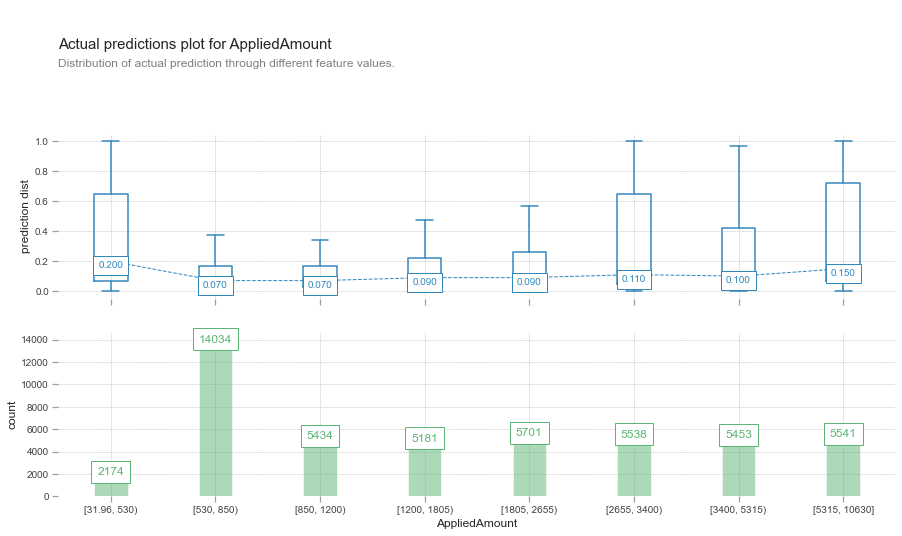

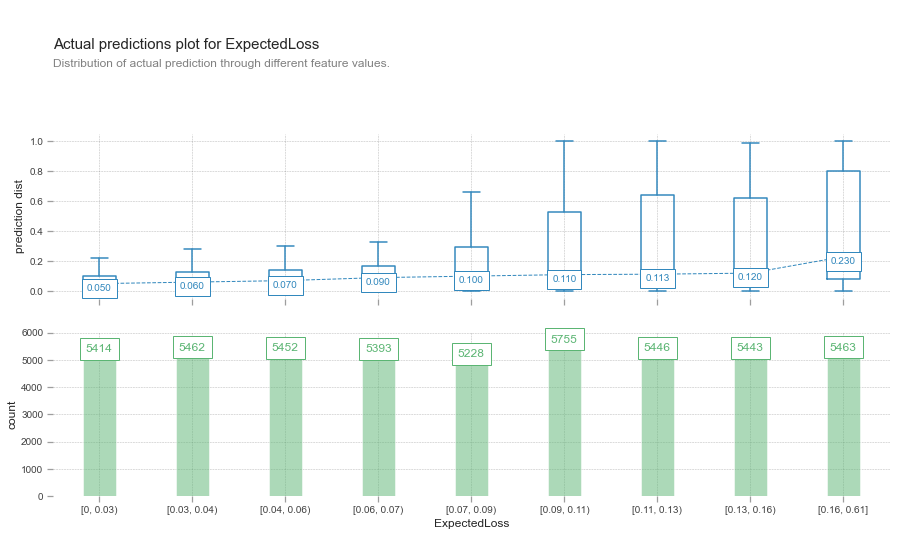

In [12]:
full_model.IV_PLOT()

#### Interpretations:

•	In the age Plot, we can notice as the age increases, the predictive probability of default remain same throughout with minimal influence except for the first two bins with age [0,29) that seem to have medium influence on the output.

•	In case of applied amount, the predictive influence is higher when the applied amount is either low or high, else it is not impacting much on predictibilty. 

•	In Expected Loss and Liabilities total, as they both increases, they tend to bring more influence on predictions.

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Partial Dependence Plots</span>
</div>


Partial Dependence Plot (PDP) shows the relationship between the outcome and the feature being investigated.

It gives the curve representation of how the features affects model results across a range of values that are present in the data. For each value of the feature, the model returns the predictions for all the values of other features, which are then averaged. The benefit of this approach is that it is model agnostic and can be implemented for any kind of classification or regression models.


In [13]:
full_model.PDP_PLOT()

#### Interpetations:

•	From above graphs, we can notice in the 1st plot,that the model is behaving quite sensitive for the Age group below 40 and as the age increases, the probability of being default decreases. 

•	Similarly if we take another feature say 'Liabilities Total', we can see the linear relationship with the outcome. The more is the liabilities of a person, the more is the chances of default.

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:em;">Difference between PDP and IV PLots</span>
</div>

•  IV plots helps to understand the importance of any particular feature, that how any feature is impacting on the predictions made. And the PDP plot of any feature also states its importance, but here the model returns the predictions for all the values of other features as well, which are then averaged over the marginal distribution.

•  IV presents feature values in bins, while PDP shows them in data points.

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Split and Compare Quantile Plots: Default Percentage Errors</span>
</div>

The split and compare quantiles helps us define a decision threshold for a 
classification problem by giving a clear understanding of the impact of our decision 
on the confusion matrix and evaluate if the model helps meet the business objectives.

To implement it, we divide our dataset into equal quantiles and then split it by 
favourable and unfavourable outcomes.

This should be used by the product owner and the business analysts to determine 
the optimum decision boundary that helps minimize the false positives and the 
negatives.


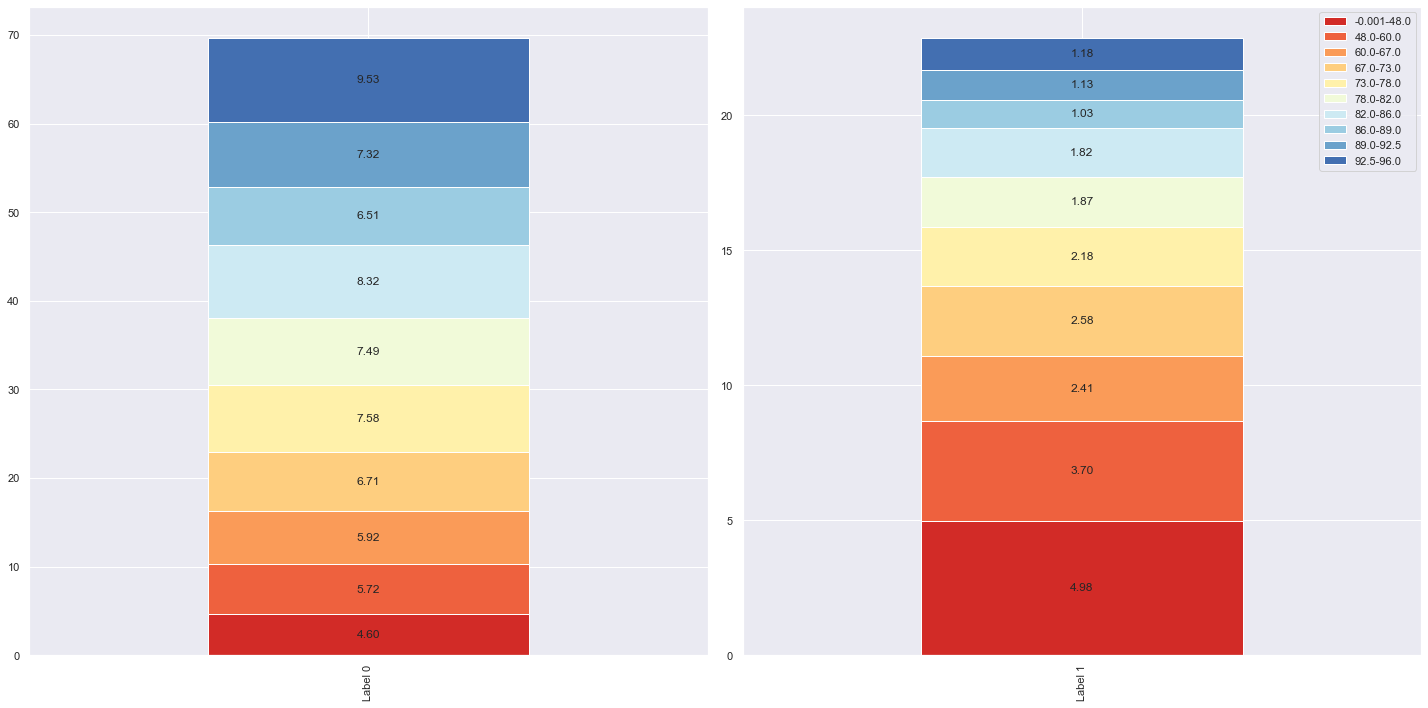

In [14]:
Show_quantile_label(df1,None)

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Split and Compare Quantile Plots: Loss of Amount</span>
</div>

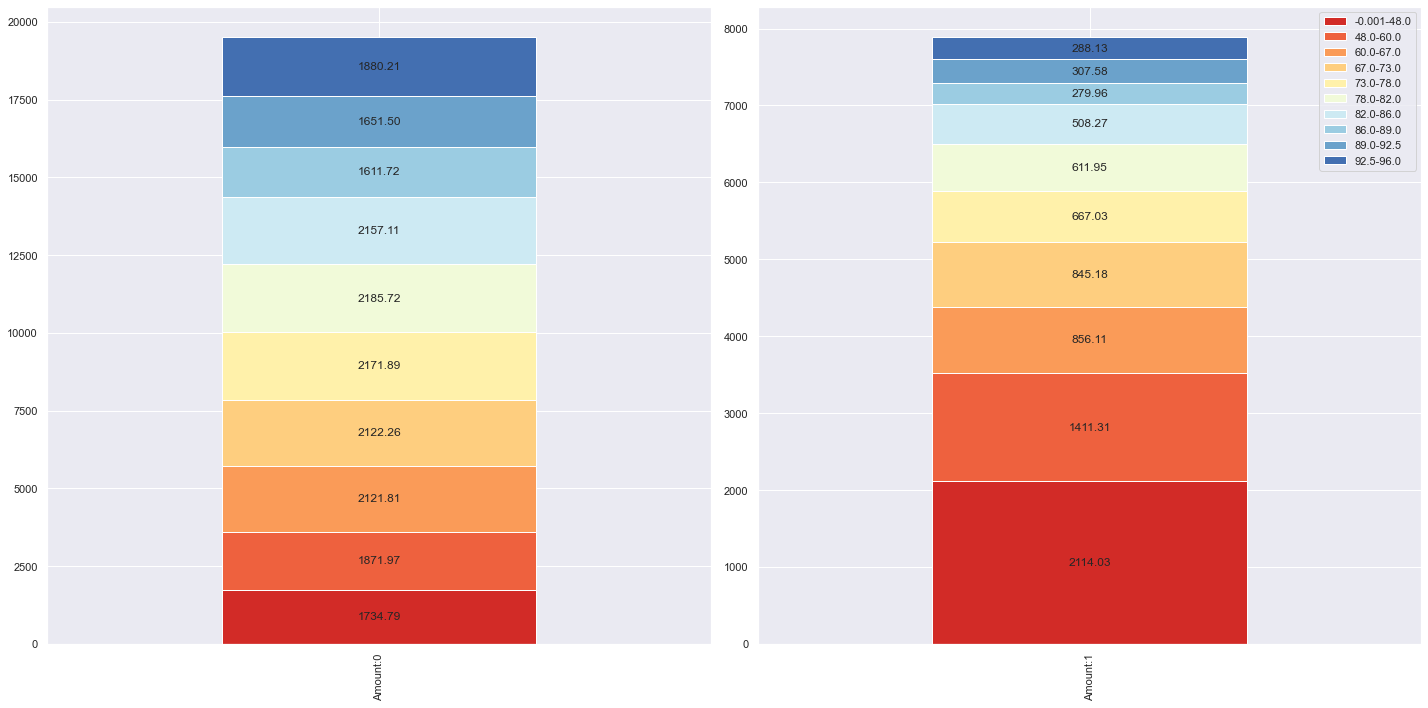

In [15]:
Show_quantile_label(None,df2)

#### Interpretations:

Every model tends to have errors while making the predictions. So, with the help of SCQ, we will be able to analyze those percentage errors.

As we can notice the two bars that are split into deciles by predicted probabilities calculated on label [0] i.e., on the likelihood of being non-defaulters. Here, the first bar represents non-defaulters and second bar as defaulters. 

Let’s assume that the business decides to give loan to customers with threshold above 89%. So, this means (9.53+7.32+1.18+1.13) 19.16% of the debtors would be identified as not likely to default, and we are offering loan to those people. However, out of this (1.18+1.13) 2.31% are the ones that will default as they fall under label 1 bar. 
Also, the red splits under label 0 shows that the predicted probability of them being a non-defaulter is significantly less that eventually makes it an error in predictions.

Similarly, we can interpret the errors in monetary terms with the help of taking applied amount feature in the picture. As explained, (288.13+307.58) 595,710 in dollars is the risk of commercial loss due to incorrect labeling out of (1880.21+1651.50+2881.3+307.58) 4,127,420 total amount.


<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Generalized Additive Models : GAM Plots</span>
</div>

Linear models are inherently explainable but, as the name implies, do not capture 
nonlinearity. Generalized additive models are a nonlinear version of the generalized 
linear models and provide an explainable and flexible approach like linear models 
while capturing nonlinearity.

Since this is an additive model with a separate function for each feature, the 
impact of each feature is known at all times. There are no hidden inner workings of 
the model making the explanation difficult. This ability makes this a “glass box” 
model and deserves a strong consideration if your other options so far are black box 
models with additional explanation added.

In [16]:
GAM.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      44.858
Link Function:                        LogitLink Log Likelihood:                                -25323.4381
Number of Samples:                        49056 AIC:                                            50736.5921
                                                AICc:                                           50736.6798
                                                UBRE:                                                3.035
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0598
Feature Function                  Lam

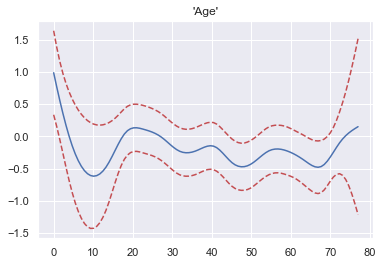

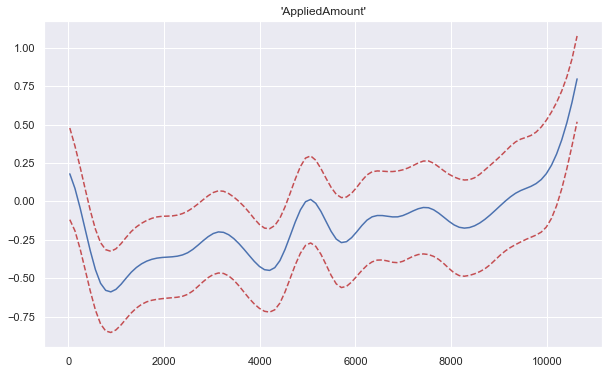

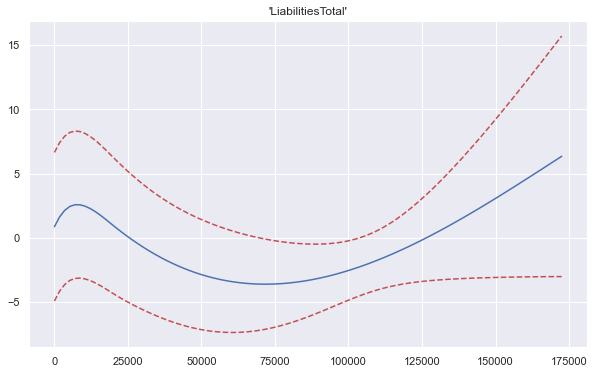

In [17]:
GAM.GAM_PLOT()

#### Interpretations:
•  The x -axis depicts the data points, while the y-axis shows the additive function of the particular feature. The red dotted lines are the confidence intervals.

•  From the above graphs, we can notice many fluctutaion's in impact that features have on model, which is nothing but the non-linearity behavior of the features while making the predictions.
Like, features ranging from the most linear (LiabilitiesTotal) to highly nonlinear 
(age) and how they have been handled separately and accurately by the GAM model.

• We are able to know the non-linearity across various data points which make it better explainable

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">CounterFactuals</span>
</div>

CounterFactuals is a method for countering the fact or reversing the fact or identifying the changes in the features that would change the outcome thereby helping in explaining the Model's behaviour. For example many times we see client coming back with a question or seeking explainations for "What's next" or "What if". So Counterfactual tells the ways that would make the decision change or what could have been different in the customer’s data that could’ve meant a different outcome for them.

In [18]:
CF.CF_EXP()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]

Query instance (original outcome : 1)


Age  AppliedAmount  ExpectedLoss  LiabilitiesTotal  Default
0  55.0        10630.0         0.088              40.0        1


Diverse Counterfactual set (new outcome: 0.0)


Age AppliedAmount ExpectedLoss LiabilitiesTotal Default
0   -        4390.0            -                -     0.0
1   -        3726.5            -                -     0.0
2   -          32.0            -                -     0.0
3   -             -  0.078926559         100976.0     0.0

#### Interpretaions:

From above, we can see the four possible options that would make the decision change or could make some changes in the customer’s data in a way, the customer's profile can be improvised in order to make it under the label of non-defaulters.

Like a slightly lesser amount that a custmer is applying loan for along with higher total liabilities can make the changes in decision from being a defaulter to non-defaulter.

### ----------------------------------------------------------------THE END------------------------------------------------------------------------------